# Sensor data prediction

Several sensors (DHT22) have been used to collect air temperature and relative humidity in different rooms (one in the living room (LR), three in the bed room (BR), one outside(O)). Unfortunately, one of the sensors produced an error and did not record any more data after about 25 h. A strong correlation between the sensors is assumed.

All temperatures (T) are given in °C, humidity (H) always refers to relative humidity in %.

In [13]:
# Import (standard) dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates


In [14]:
# Import data and get an overview about data
df = pd.read_csv("dht_data.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T_LR      1320 non-null   float64
 1   H_LR      1320 non-null   float64
 2   T_BR1     1320 non-null   float64
 3   H_BR1     1320 non-null   float64
 4   T_BR3     327 non-null    float64
 5   H_BR3     327 non-null    float64
 6   T_BR2     1320 non-null   float64
 7   H_BR2     1320 non-null   float64
 8   T_O       1320 non-null   float64
 9   H_O       1320 non-null   float64
 10  datetime  1320 non-null   object 
dtypes: float64(10), object(1)
memory usage: 113.6+ KB
None


,T_LR,H_LR,T_BR1,H_BR1,T_BR3,H_BR3,T_BR2,H_BR2,T_O,H_O,datetime
0,24.300002,46.900000,22.1,55.600004,17.600000,72.8,20.2,60.600004,4.2,91.5,2026-01-29 09:30:56
1,24.300002,47.100004,22.1,55.500000,17.600000,72.8,20.2,60.600004,4.3,91.4,2026-01-29 09:35:57
2,24.200000,47.400000,22.0,55.400000,17.500000,73.1,20.1,60.000000,4.4,90.9,2026-01-29 09:40:57
3,24.300002,47.500000,22.0,55.500000,17.400000,73.6,20.0,60.300000,4.4,91.0,2026-01-29 09:45:58
4,24.400000,47.900000,21.9,55.700000,17.300002,73.9,20.0,60.700000,4.5,90.5,2026-01-29 09:50:58


In [15]:
# convert datetime into actual datetime objects
df.datetime = pd.to_datetime(df.datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   T_LR      1320 non-null   float64       
 1   H_LR      1320 non-null   float64       
 2   T_BR1     1320 non-null   float64       
 3   H_BR1     1320 non-null   float64       
 4   T_BR3     327 non-null    float64       
 5   H_BR3     327 non-null    float64       
 6   T_BR2     1320 non-null   float64       
 7   H_BR2     1320 non-null   float64       
 8   T_O       1320 non-null   float64       
 9   H_O       1320 non-null   float64       
 10  datetime  1320 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 113.6 KB


In [16]:
# split dataset in complete (nonan) and incomplete part (nan), where temperature data is missing
df_nonan = df[df["T_BR3"].notna()].copy()
df_nan = df[df["T_BR3"].isna()].copy()
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 327 to 1319
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   T_LR      993 non-null    float64       
 1   H_LR      993 non-null    float64       
 2   T_BR1     993 non-null    float64       
 3   H_BR1     993 non-null    float64       
 4   T_BR3     0 non-null      float64       
 5   H_BR3     0 non-null      float64       
 6   T_BR2     993 non-null    float64       
 7   H_BR2     993 non-null    float64       
 8   T_O       993 non-null    float64       
 9   H_O       993 non-null    float64       
 10  datetime  993 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 93.1 KB


<Axes: >

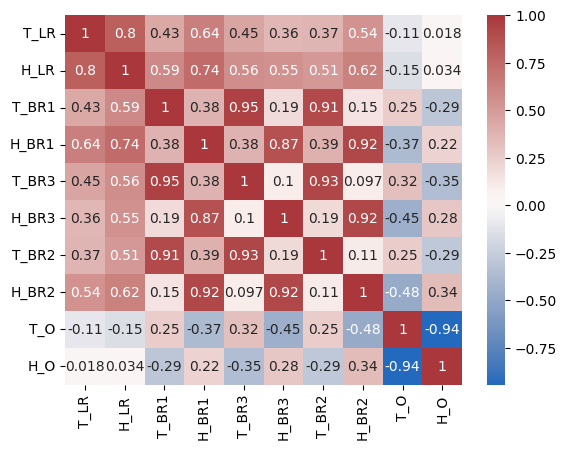

In [17]:
# Visualisation to find correlation
# sns.pairplot(data=df_nonan)
sns.heatmap(data=df_nonan.corr(numeric_only=True), cmap="vlag", annot=True)

### Predict missing values

Train and test LinearRegression and RandomForestRegressor models on complete part of the dataset. Validate the models using the R2 scores (over-underfitting) and compare the two different approaches.

In [18]:
# LinearRegression test to predict temperature T_BR3 (missing values but linear correlation)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

X = df_nonan[["T_LR", "T_BR1", "T_BR2"]]
y = df_nonan["T_BR3"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% test set
    random_state=42     # reproducibility
)

# define pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# cross validation
scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("R2 Training Set:", scores.mean())

# Model training
lr_pipeline.fit(X_train, y_train)

# prediction on test set
y_pred = lr_pipeline.predict(X_test)


#  evaluation metrics for linear regression
r2 = r2_score(y_test, y_pred)

print("R2 test set:", r2)



R2 Training Set: 0.9277238929750196
R2 test set: 0.9258061699171911


In [19]:
# RF Regression to predict temperature T_BR3 (missing values but linear correlation)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df_nonan[["T_LR", "T_BR1", "T_BR2"]]
y = df_nonan["T_BR3"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% test set
    random_state=42     # reproducibility
)

# Model training
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

# cross validation
scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("R2 Training Set:", scores.mean())

rf_model.fit(X_train, y_train)

# prediction on test set
y_pred = rf_model.predict(X_test)


#  evaluation metrics for linear regression
r2 = r2_score(y_test, y_pred)

print("R2 test set:", r2)

R2 Training Set: 0.9324052184661593
R2 test set: 0.972582645633315


Play around with some hyperparameters and see how the values change. How does the result behave if you take other data fields into consideration?

Use the RF Regression to predict the missing temperature values.

In [20]:
# apply linear regression to predict temperature

X_predict = df_nan[["T_LR", "T_BR1", "T_BR2"]]

df_nan["T_BR3"] = rf_model.predict(X_predict)
df_nan.info()



<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 327 to 1319
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   T_LR      993 non-null    float64       
 1   H_LR      993 non-null    float64       
 2   T_BR1     993 non-null    float64       
 3   H_BR1     993 non-null    float64       
 4   T_BR3     993 non-null    float64       
 5   H_BR3     0 non-null      float64       
 6   T_BR2     993 non-null    float64       
 7   H_BR2     993 non-null    float64       
 8   T_O       993 non-null    float64       
 9   H_O       993 non-null    float64       
 10  datetime  993 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 93.1 KB


Do this approach now with humidity (Without doing the cross validation) and see which model performs better judged by the R2 of the test set.

Recombine and visualise the data.

In [21]:
# create new df including the predicted values
df_pred = pd.concat([df_nonan, df_nan], axis=0)
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1320 entries, 0 to 1319
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   T_LR      1320 non-null   float64       
 1   H_LR      1320 non-null   float64       
 2   T_BR1     1320 non-null   float64       
 3   H_BR1     1320 non-null   float64       
 4   T_BR3     1320 non-null   float64       
 5   H_BR3     327 non-null    float64       
 6   T_BR2     1320 non-null   float64       
 7   H_BR2     1320 non-null   float64       
 8   T_O       1320 non-null   float64       
 9   H_O       1320 non-null   float64       
 10  datetime  1320 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 123.8 KB


In [22]:
# split the data into two dataframes for humidity and temperature.
df_T = df_pred[["datetime", "T_LR", "T_O", "T_BR1", "T_BR2", "T_BR3"]]
df_H = df_pred[["datetime", "H_LR", "H_O", "H_BR1", "H_BR2", "H_BR3"]]

# melt into long table for visualisation
df_T_long = pd.melt(df_T, ["datetime"])
df_H_long = pd.melt(df_H, ["datetime"])

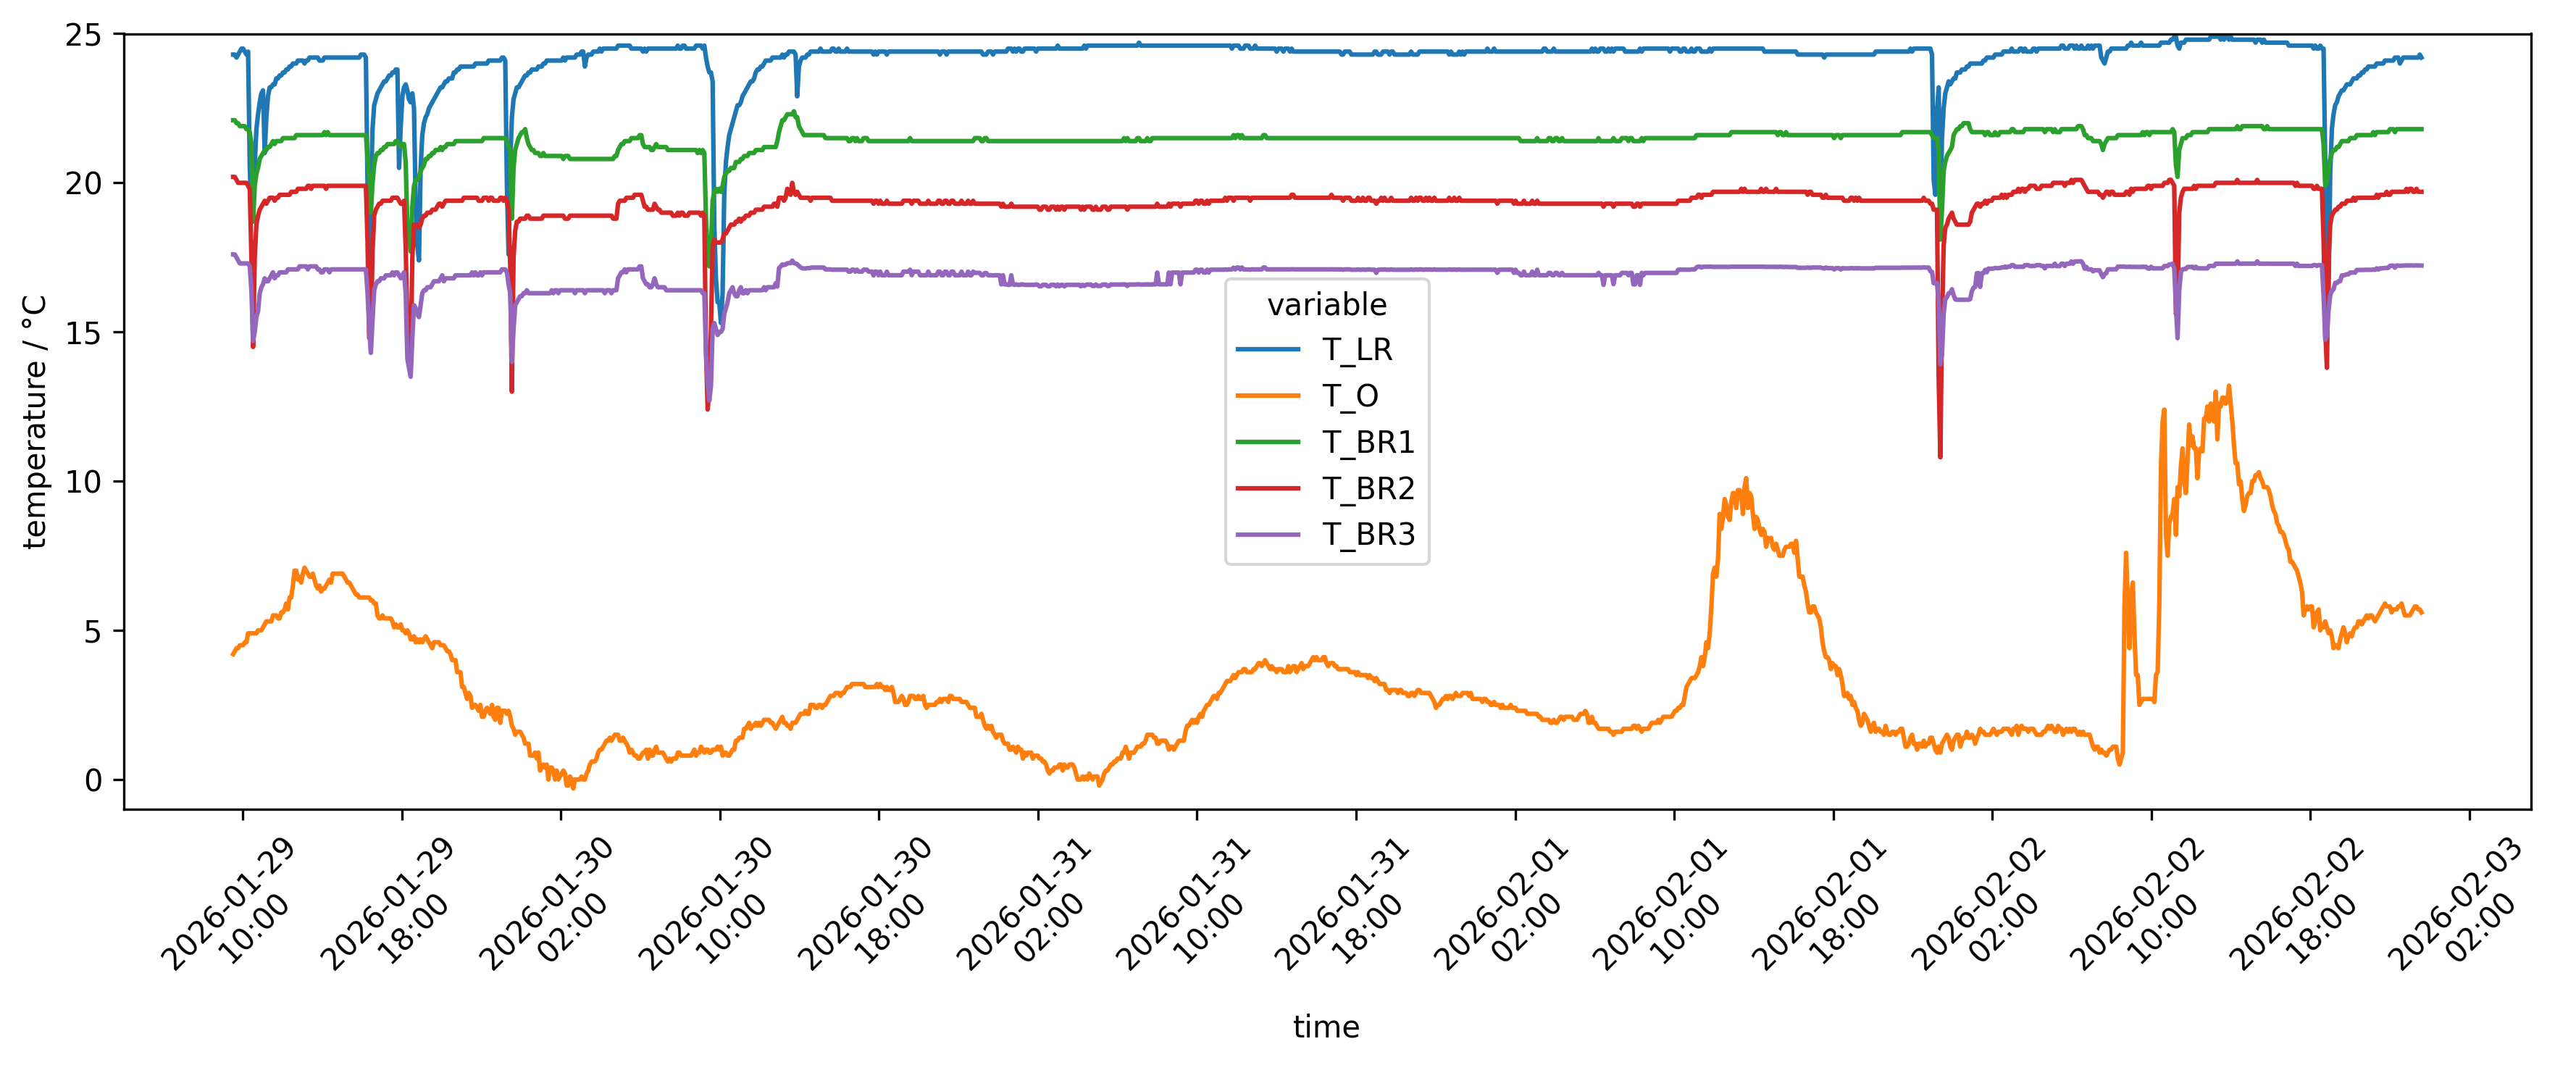

In [23]:
# Temperature plot. Some lines have been commented out (optimised settings for the measured data only)

fig = plt.figure(figsize=(12,5), dpi=300)
T_plot = sns.lineplot(data=df_T_long, x="datetime", y="value", hue="variable")
T_plot.set_ylim(-1, 25)
# T_plot.set_xlim([datetime.datetime(2026, 1, 29, 9,30,0), datetime.datetime(2026,1,30,12,0,0)])
T_plot.tick_params("x", rotation=45)
T_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
T_plot.xaxis.set_major_locator(mdates.HourLocator(interval=8))  # tick every 8 hours
# T_plot.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # tick every 2 hours
T_plot.yaxis.set_label_text("temperature / °C")
T_plot.xaxis.set_label_text("time")
# plt.legend(loc=(0.91,0.16))
plt.tight_layout()
plt.show()

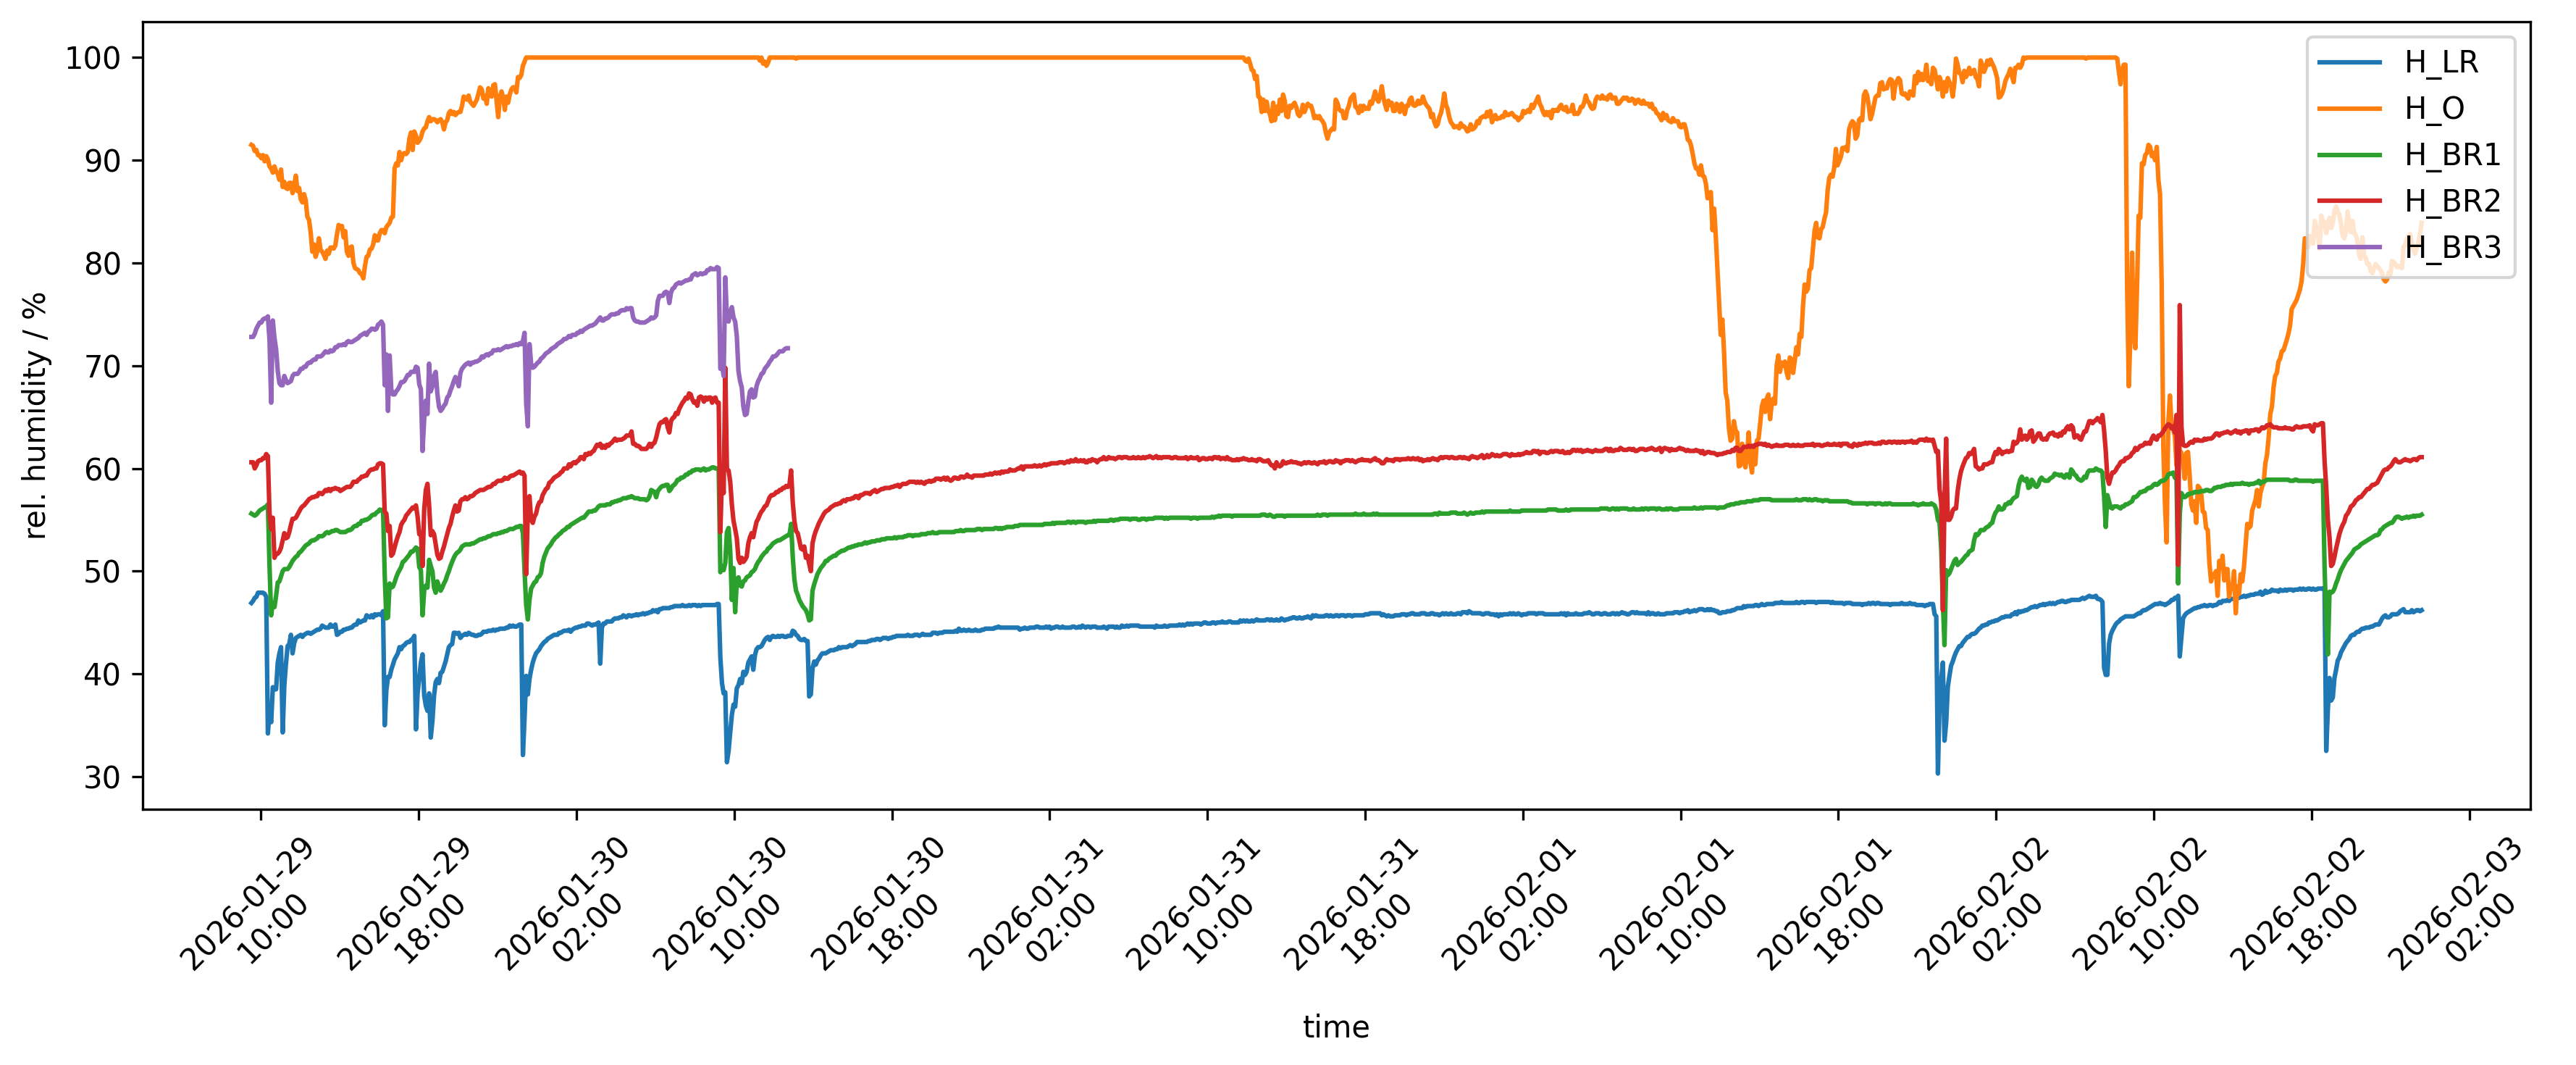

In [24]:
# Humidity plot. Some lines have been commented out (optimised settings for the measured data only)

fig = plt.figure(figsize=(12,5), dpi=300)
H_plot = sns.lineplot(data=df_H_long, x="datetime", y="value", hue="variable")
# H_plot.set_xlim([datetime.datetime(2026,1,29,9,30,0,0), datetime.datetime(2026,1,30,12,30,0,0)])
H_plot.tick_params("x", rotation=45)
H_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
H_plot.xaxis.set_major_locator(mdates.HourLocator(interval=8))  # every 8 hours
# H_plot.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # every 2 hours
H_plot.yaxis.set_label_text("rel. humidity / %")
H_plot.xaxis.set_label_text("time")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

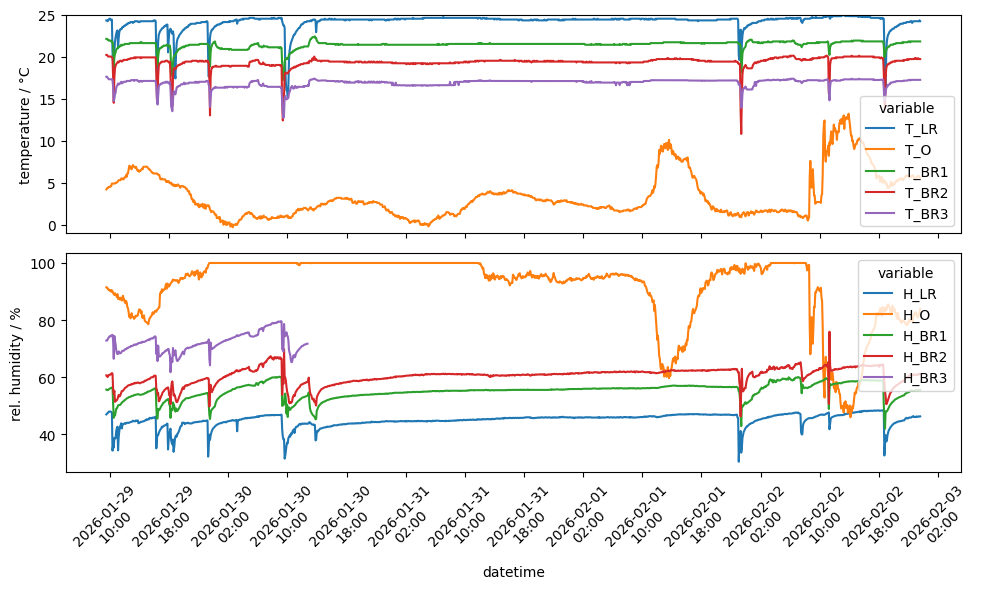

In [25]:
# or as subplot

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(10, 6)
)

T_plot = sns.lineplot(data=df_T_long, x="datetime", y="value", hue="variable", ax=ax1)
T_plot.set_ylim(-1, 25)
T_plot.yaxis.set_label_text("temperature / °C")
T_plot.xaxis.set_label_text("time")

H_plot = sns.lineplot(data=df_H_long, x="datetime", y="value", hue="variable", ax=ax2)
H_plot.yaxis.set_label_text("rel. humidity / %")

ax2.tick_params("x", rotation=45)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=8))  # tick every 8 hours

plt.tight_layout()
plt.show()